In [1]:
pip install SimpleITK==1.2.4

     |████████████████████████████████| 42.5MB 97kB/s 


In [2]:
pip install tensorflow==1.9

     |████████████████████████████████| 51.1MB 83kB/s 
     |████████████████████████████████| 573kB 44.5MB/s 
     |████████████████████████████████| 3.3MB 45.1MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 46.0.0
    Uninstalling setuptools-46.0.0:
      Successfully uninstalled setuptools-46.0.0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [3]:
from google.colab import drive # to mount google drive
import os
drive.mount('/content/gdrive') # google drive mounting
os.chdir('/content/gdrive/My Drive/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization-master') # CD to project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from model import build_model  #Segmentation model
import matplotlib.pyplot as plt # to plot images
import pandas as pd # to perform operations on dataframe
from scipy.ndimage import zoom # to resize input images
import cv2 # opencv module to perform operations on images
import keras.backend as K #Keras deep framework
from keras.utils import Sequence
# from keras.callbacks.callbacks import LambdaCallback
# import cv2

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [0]:
class GenerateData(Sequence):
    def __init__(self, data, input_shape, output_channels, batch_size): 
        self.data = data
        self.input_shape = input_shape
        self.output_channels = output_channels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        imgs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        data_x = np.empty((self.batch_size,) + self.input_shape, dtype=np.float32)
        labels = np.empty((self.batch_size, self.output_channels) + self.input_shape[1:], dtype=np.uint8)

        for index, img in enumerate(imgs):
            data_x[index] = np.array([preprocess(read_img(img[m]), self.input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
            labels[index] = preprocess_label(read_img(img['seg']), self.input_shape[1:])[None, ...]
        
        # batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # print("X shape",data_x.shape)
        # print("Y shape",labels.shape)
        return data_x, labels

In [0]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))


def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):  # here 155 is no of slices and in shape it will take new resize values.
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):    #for normalization
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std() #standard deviation
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET ? label 4), the peritumoral edema (ED ? label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET ? label 1)
    """
    # print(img.shape)
    # print(np.unique(img))
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true) # flatten converts n-dimensional array into 1 d array 
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + 1e-8)

In [7]:
input_shape = (4, 96, 112, 112)  # 4 is four types of images
output_channels = 3   # three types of tumor
model = build_model(input_shape=input_shape, output_channels=3)
model.load_weights('weights/weights.epoch_100-loss_-0.14610-dice_0.64230-val_dice_0.58464.hdf5')

# sample = {'t1': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1.nii.gz', 
#            't2': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t2.nii.gz', 
#            't1ce': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1ce.nii.gz', 
#            'flair': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_flair.nii.gz', 
#            'seg': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_seg.nii.gz'}

val_samples=[
             {'t1': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1.nii.gz', 
              't2': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t2.nii.gz', 
              't1ce': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1ce.nii.gz', 
              'flair': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz', 
              'seg': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_seg.nii.gz'},
             
              {'t1': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1.nii.gz', 't2': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t2.nii.gz', 't1ce': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_flair.nii.gz', 'seg': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_seg.nii.gz'}]

sample = val_samples[0]
print(sample)

data_x = np.empty((1,) + input_shape, dtype=np.float32)
labels = np.empty((1, output_channels) + input_shape[1:], dtype=np.uint8)
labels_original = np.empty((1, output_channels) + (96, 240, 240), dtype=np.uint8)

data_x[0] = np.array([preprocess(read_img(sample[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32) # images given to model
labels[0] = preprocess_label(read_img(sample['seg']), input_shape[1:])[None, ...]  #resized segmentation part for comparision with prediction model
labels_original[0] = preprocess_label(read_img(sample['seg']), (96, 240, 240))[None, ...]

{'t1': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_seg.nii.gz'}


In [0]:
preds = model.predict(data_x)[0]

In [9]:
t1 = resize(read_img(sample['t1']), (96, 112, 112))
t2 = resize(read_img(sample['t2']), (96, 112, 112))
t1ce = resize(read_img(sample['t1ce']), (96, 112, 112))
flair = resize(read_img(sample['flair']), (96, 112, 112))
for i in range(96):
    pred = preds[:, i,:,:]  # [output_channel(three types of tumor), slice no, height, width]
    pred = np.transpose(pred, (1, 2, 0))  # (height, width, output_channel(three types of tumor) at 0th position )
    pred = np.rint(pred)
    pred = pred*255
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    pred_gray = pred_gray.astype(np.uint8)
    f, ax_arr = plt.subplots(1, 6, figsize=(15,15))  #(row, no.of images, grid size)
    ax_arr[0].imshow(pred_gray, cmap='gray', vmin=0, vmax=255)
    ax_arr[0].set_title("slice_no:%s gray"%i)
    ax_arr[1].imshow(pred_gray, cmap='gray', vmin=0, vmax=1)
    ax_arr[1].set_title("binary")
    ax_arr[2].imshow(t1[i], cmap='gray')
    ax_arr[2].set_title("t1")
    ax_arr[3].imshow(t2[i], cmap='gray')
    ax_arr[3].set_title("t2")
    ax_arr[4].imshow(t1ce[i], cmap='gray')
    ax_arr[4].set_title("t1c")
    ax_arr[5].imshow(flair[i], cmap='gray')
    ax_arr[5].set_title("flair")
    plt.show() 

Output hidden; open in https://colab.research.google.com to view.

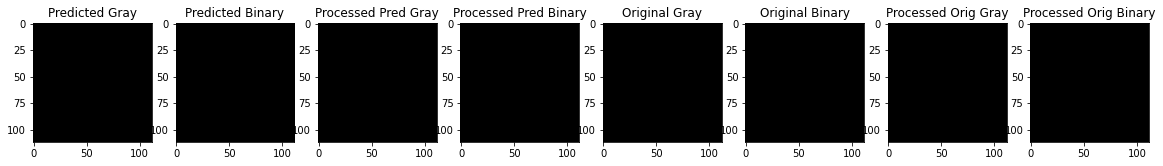

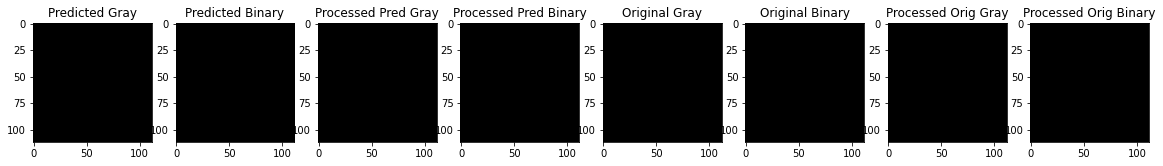

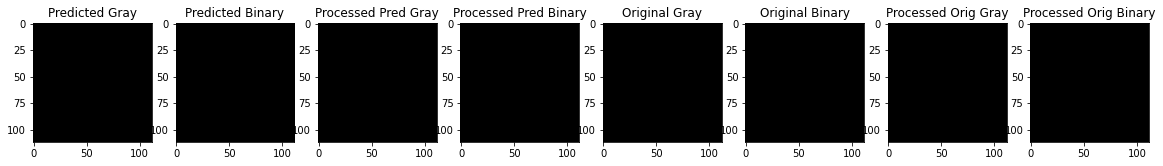

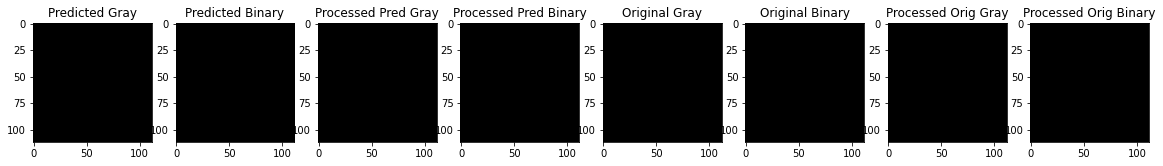

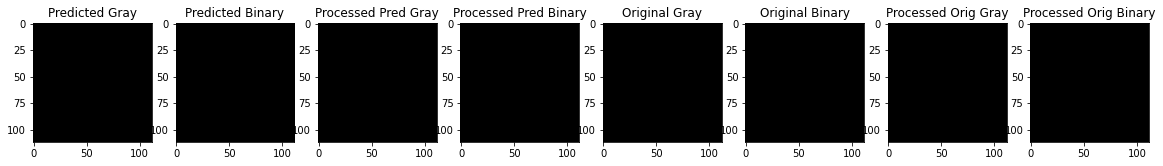

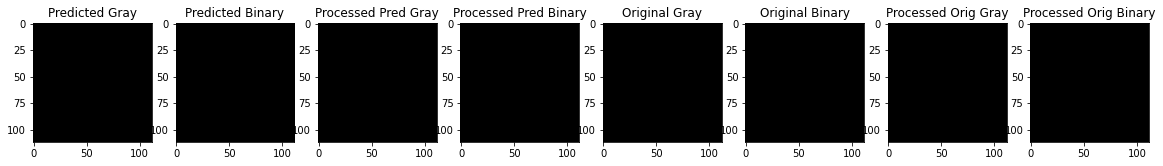

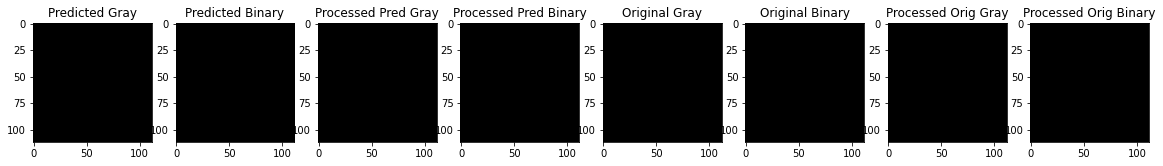

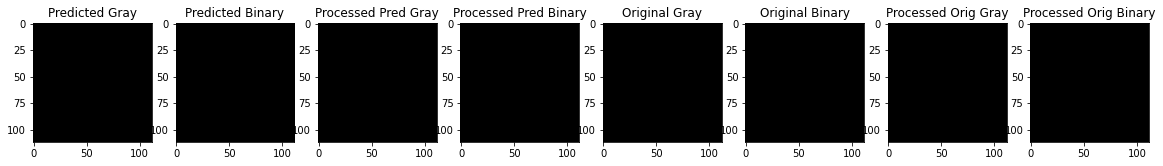

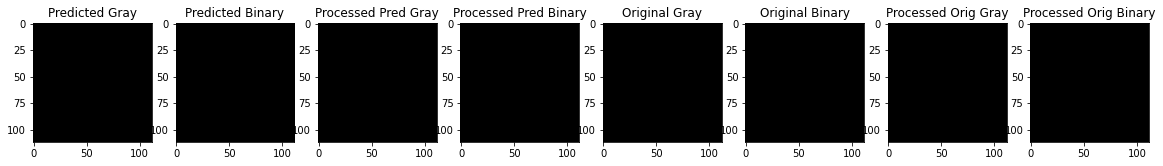

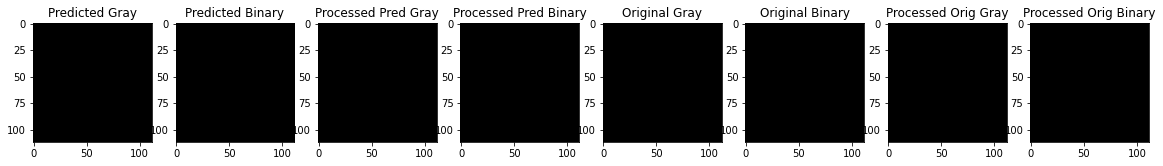

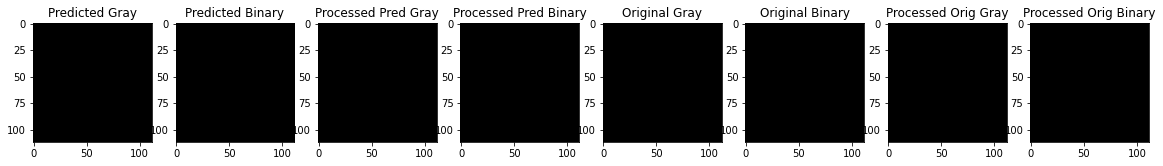

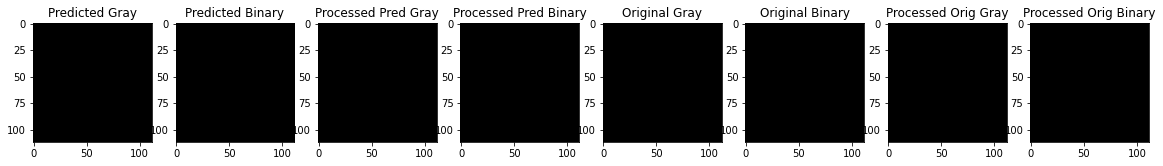

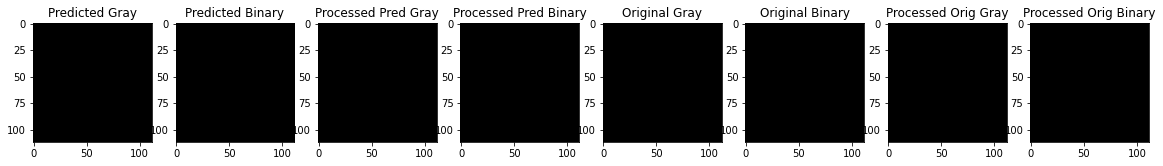

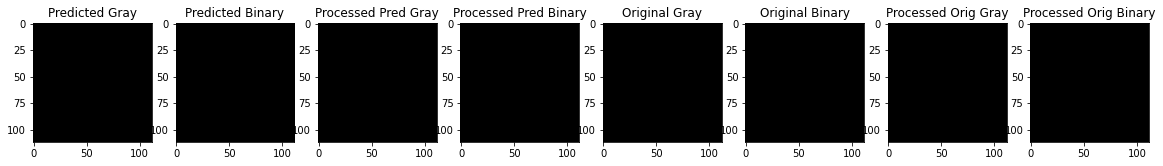

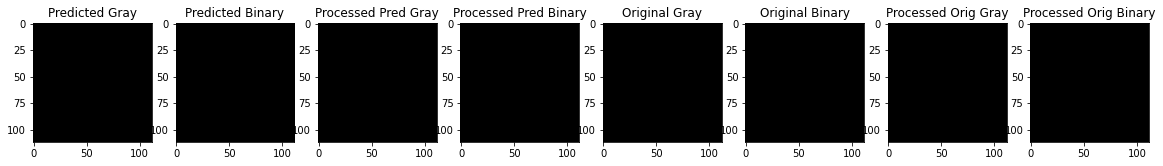

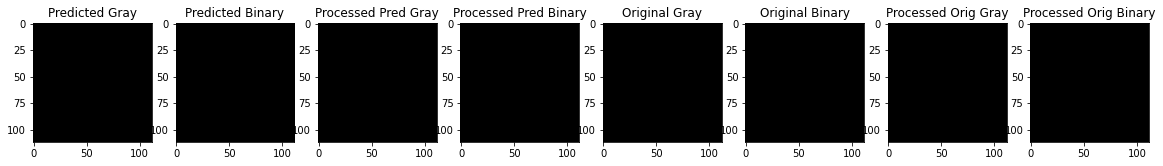

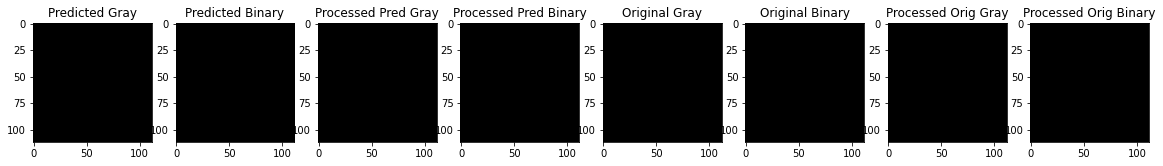

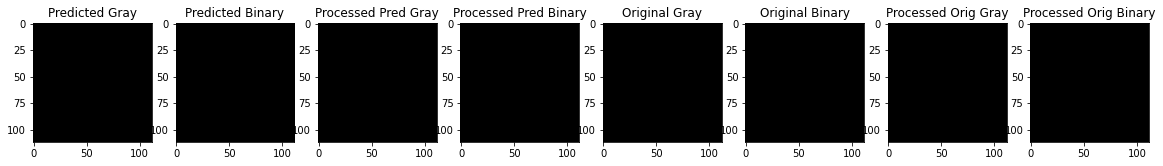

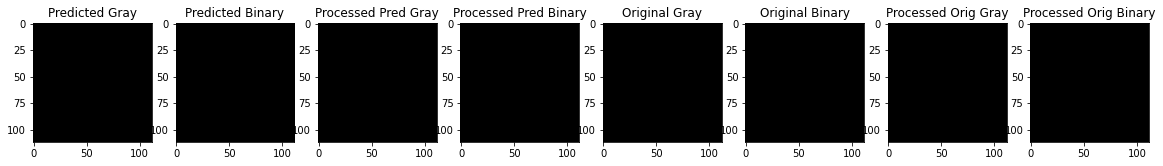

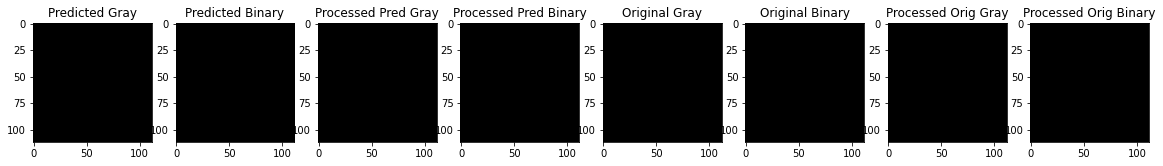

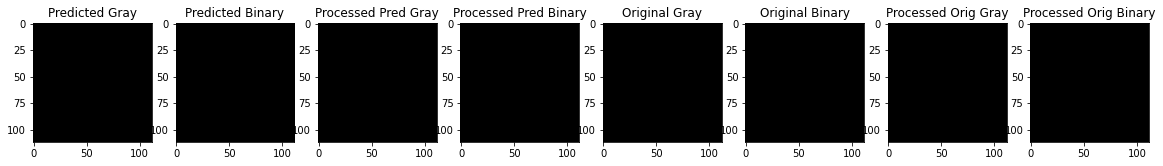

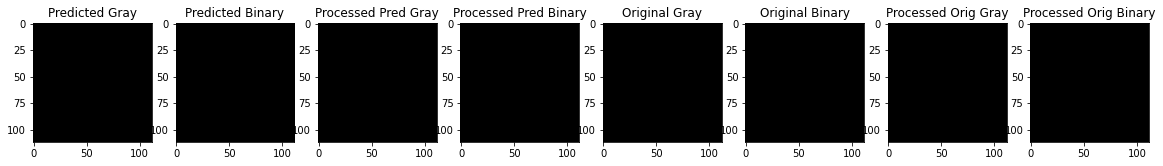

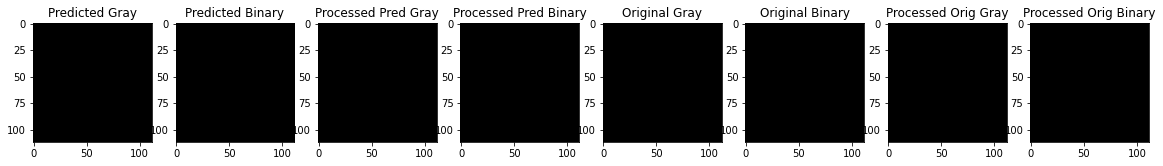

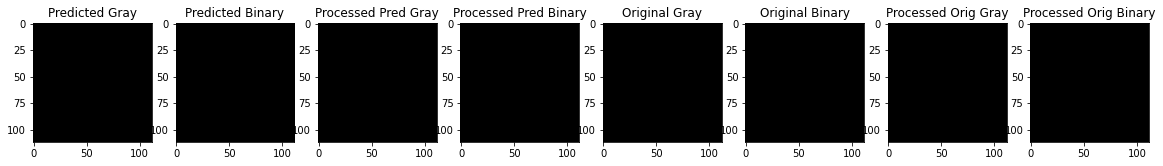

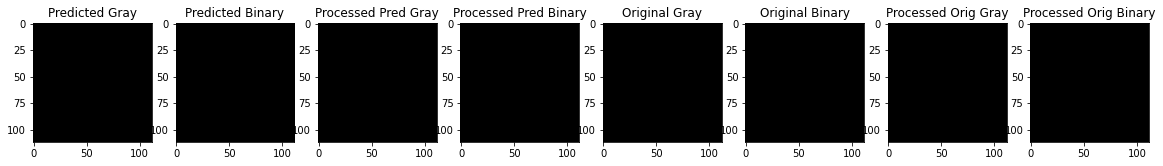

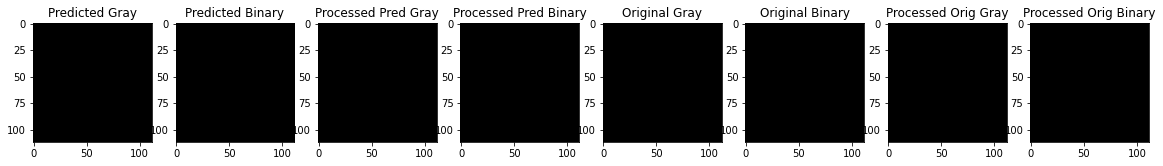

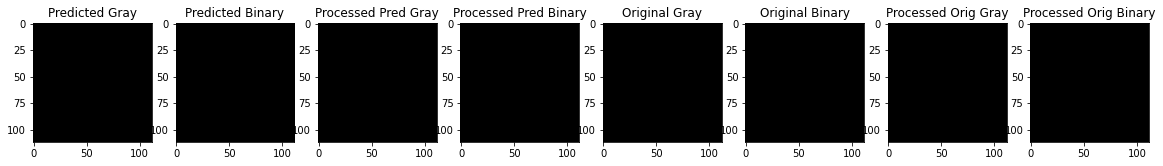

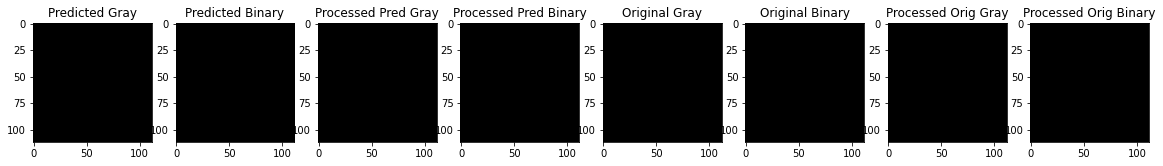

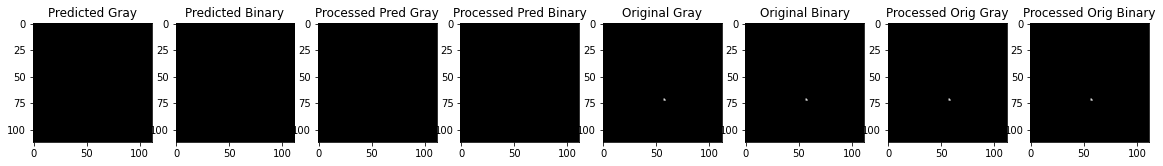

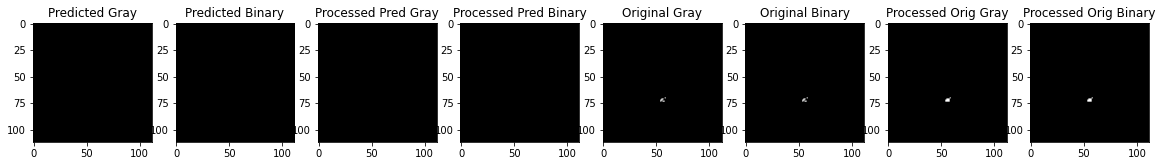

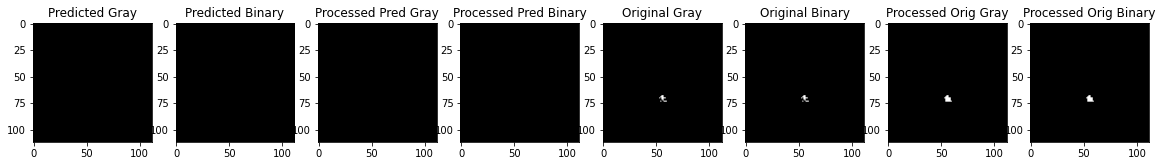

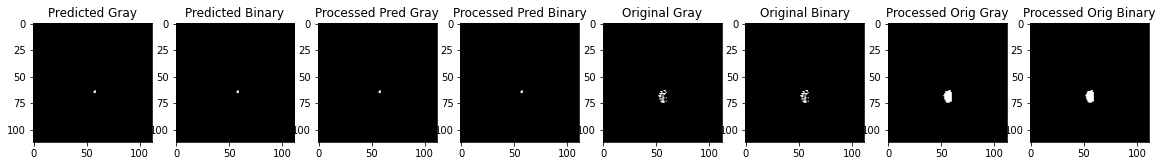

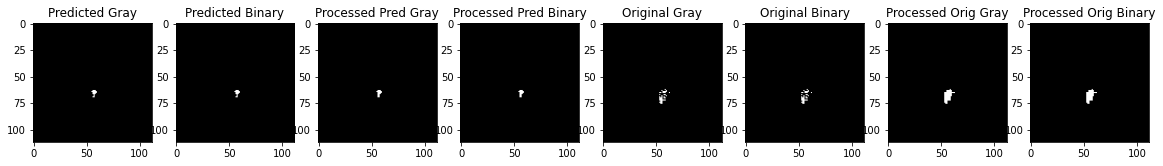

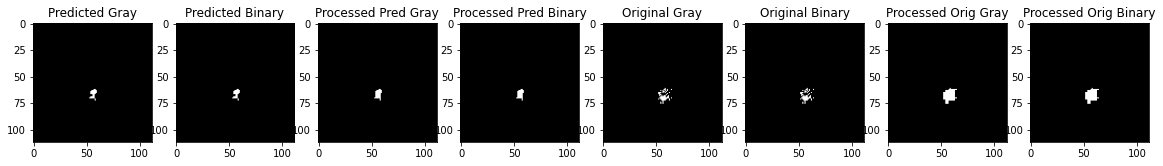

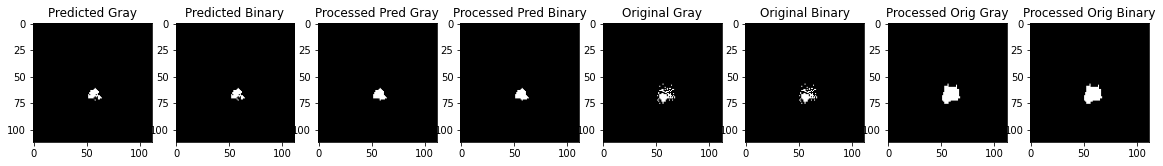

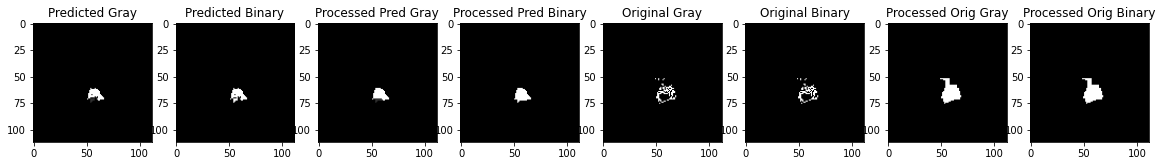

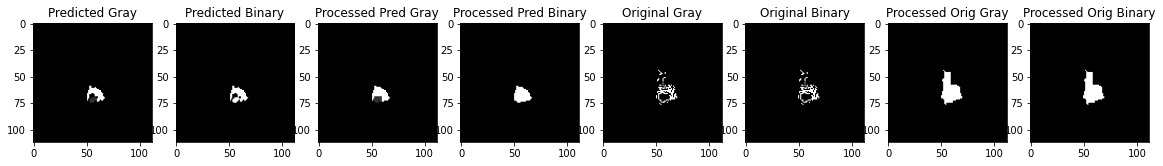

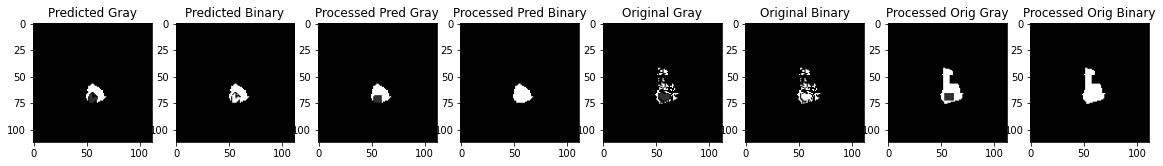

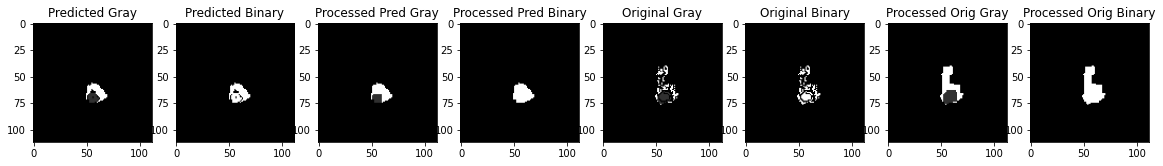

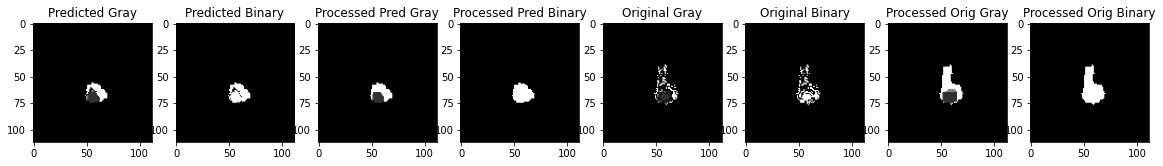

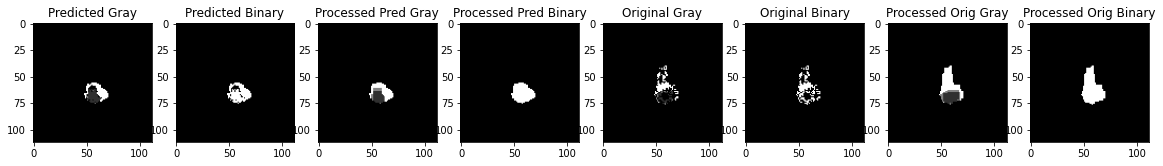

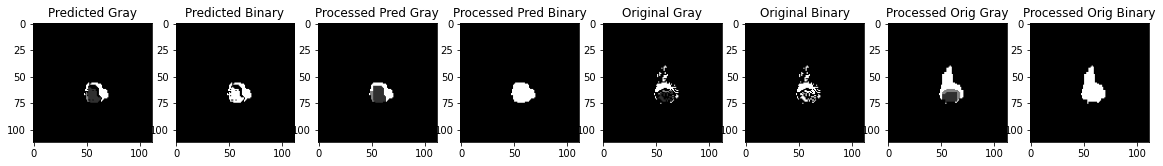

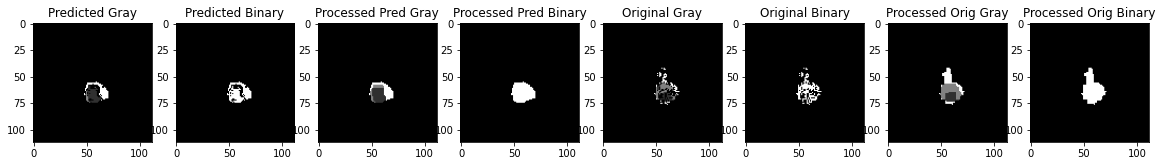

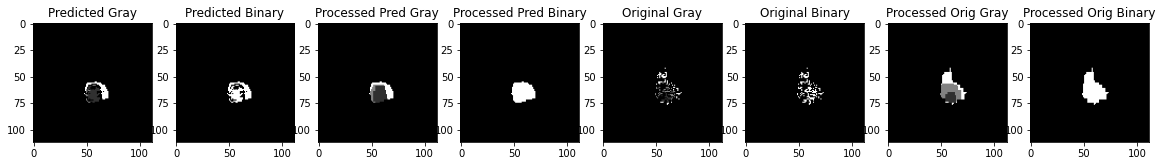

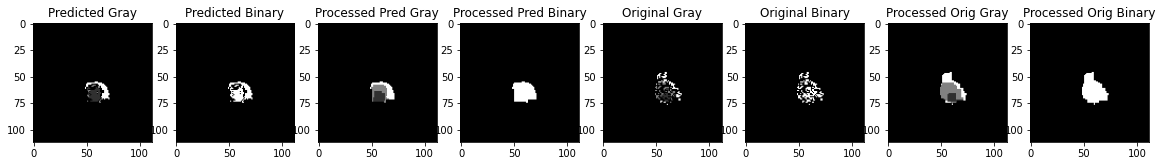

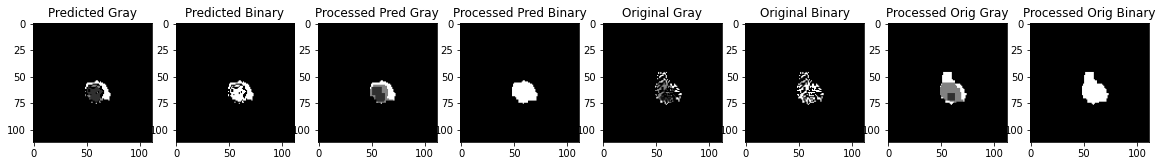

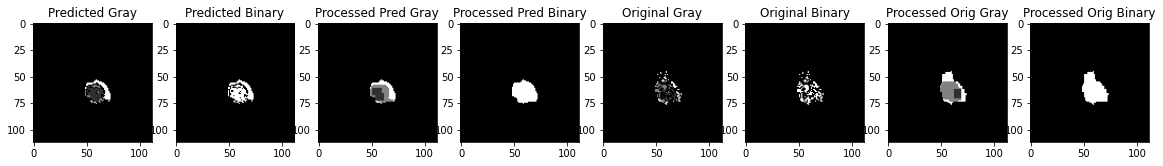

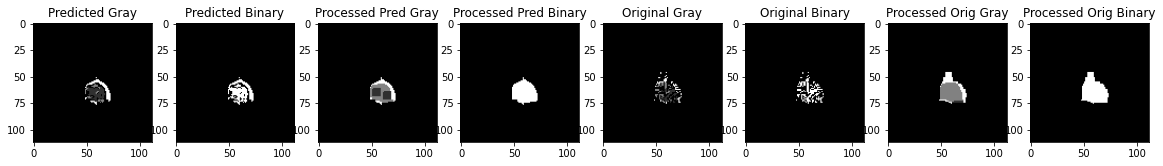

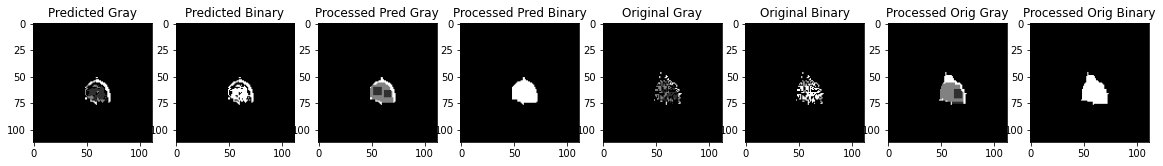

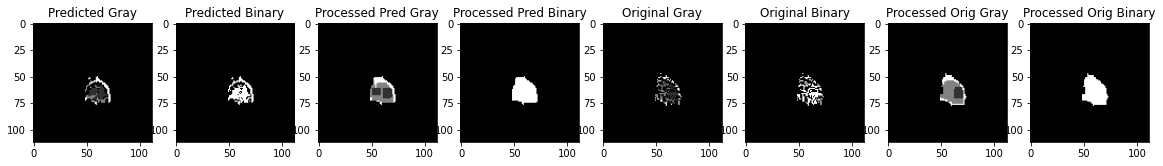

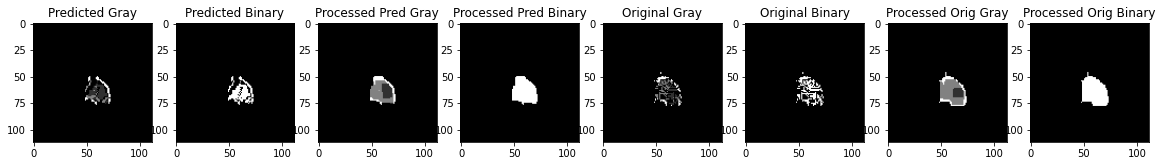

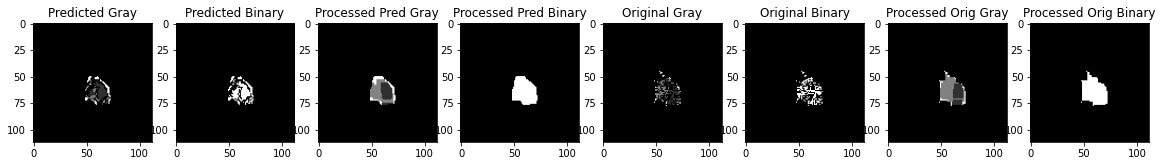

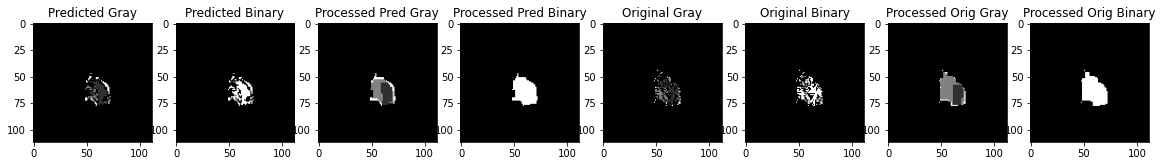

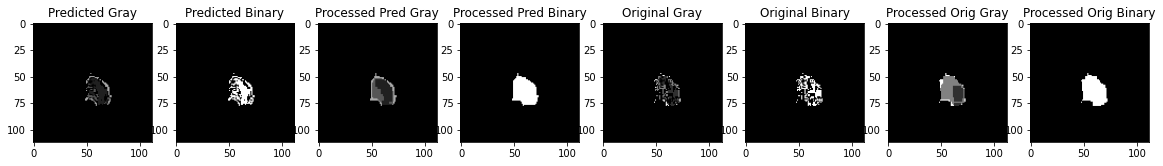

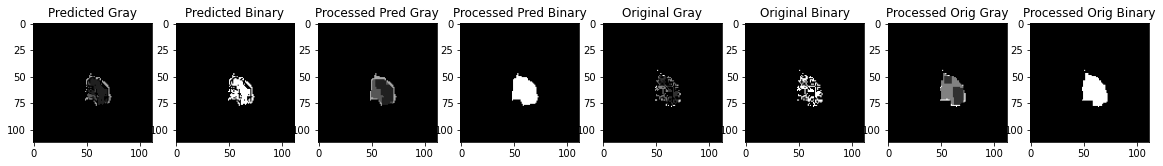

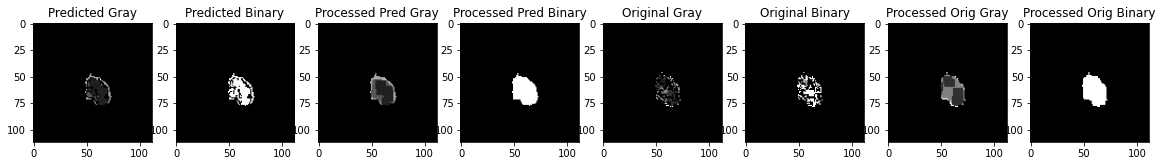

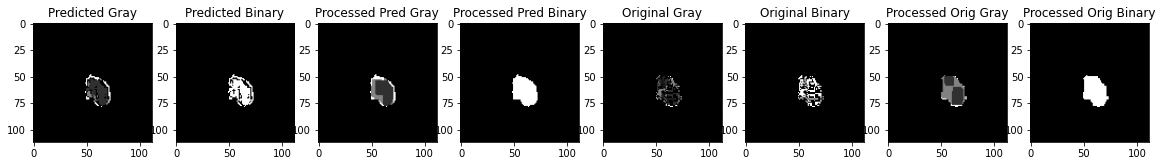

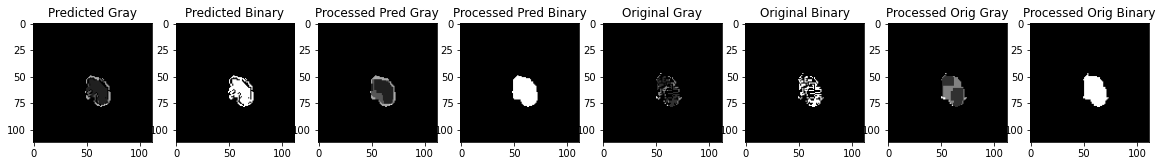

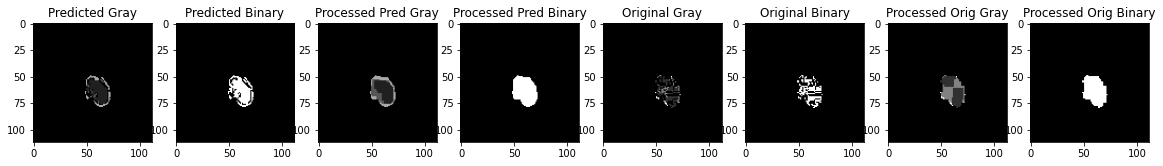

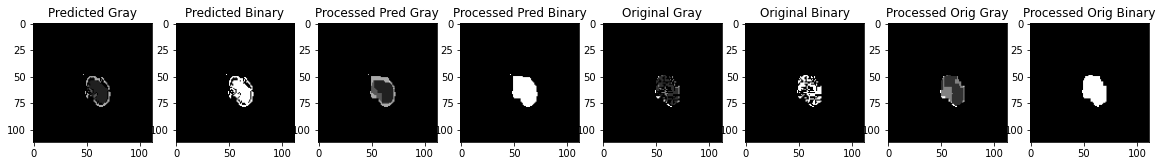

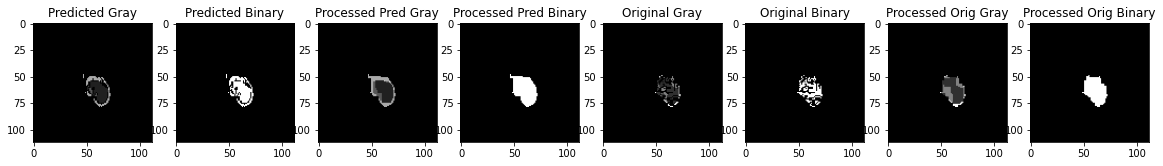

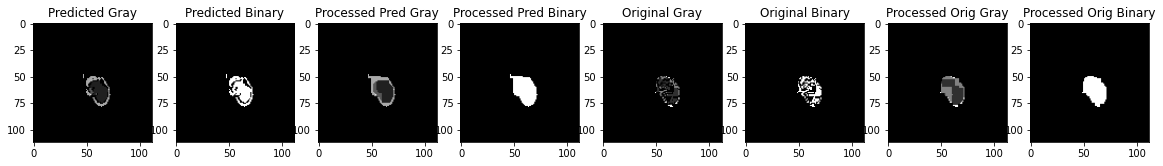

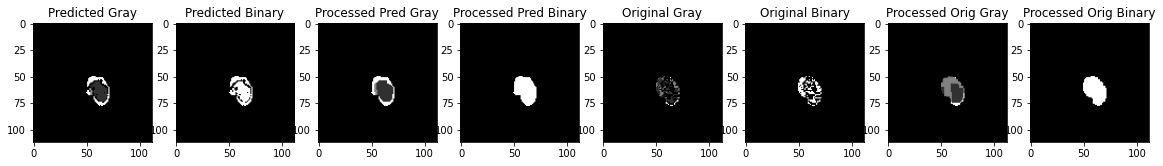

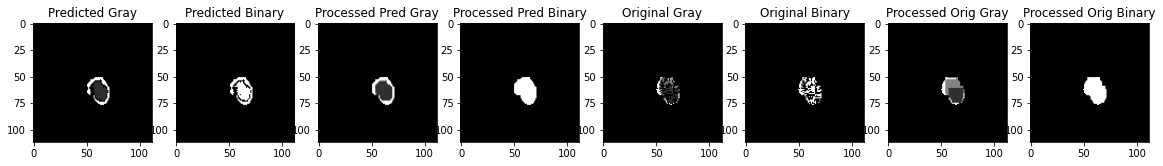

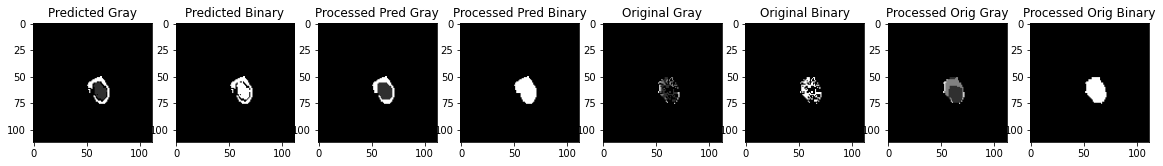

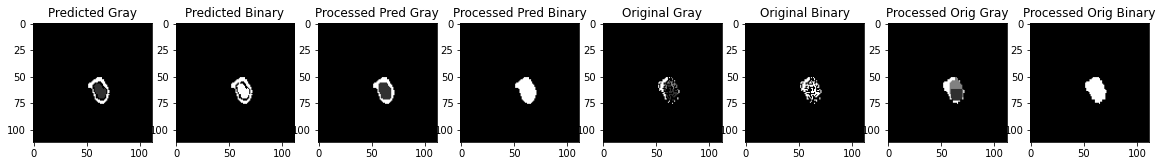

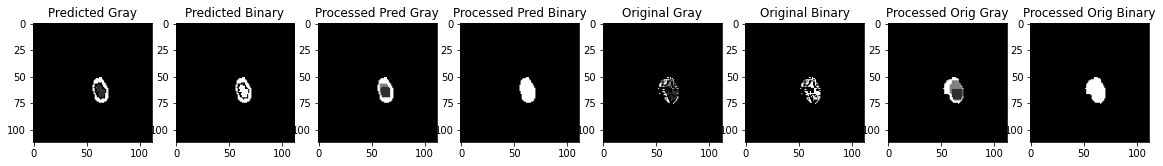

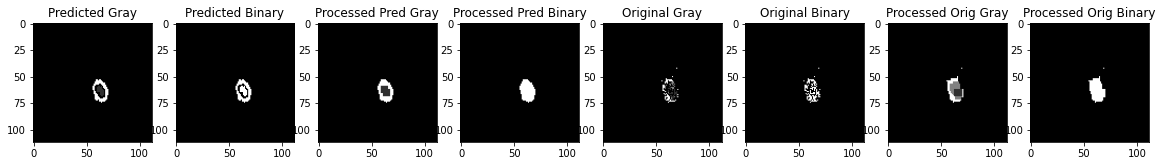

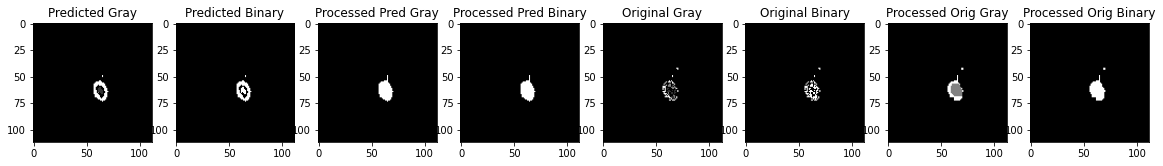

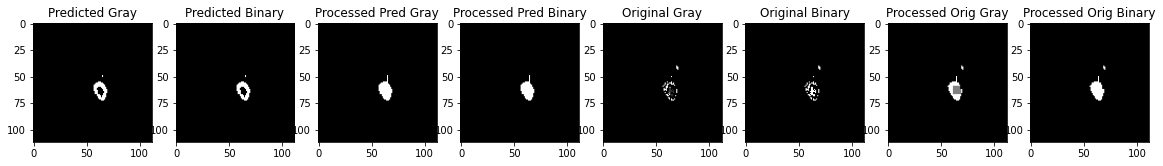

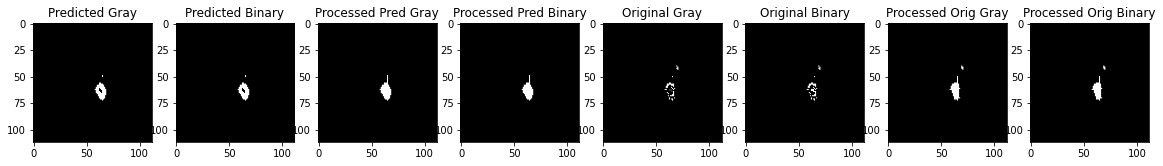

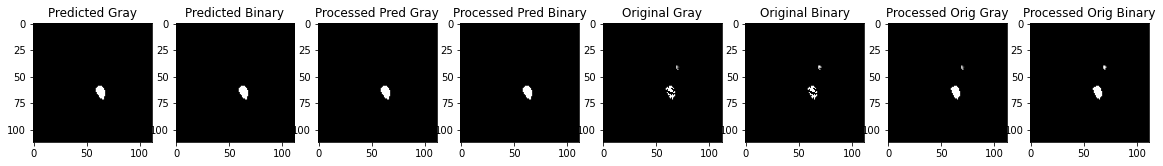

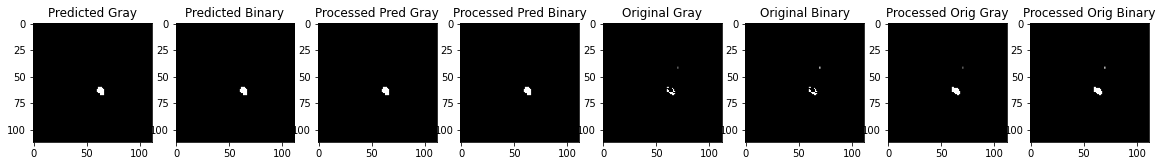

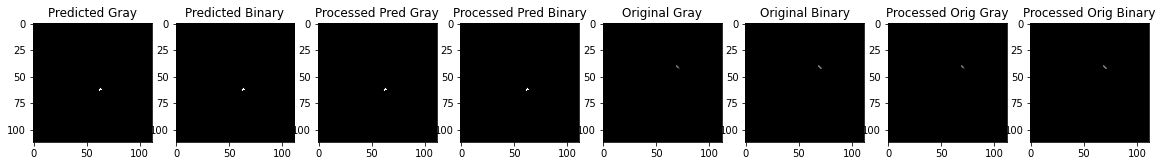

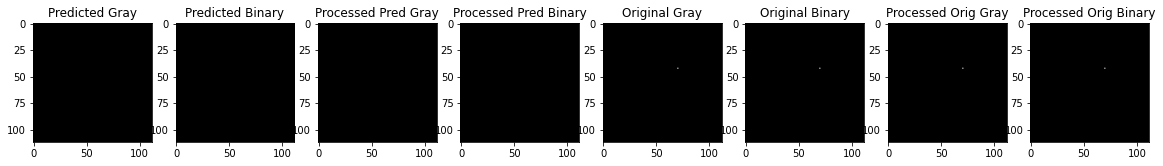

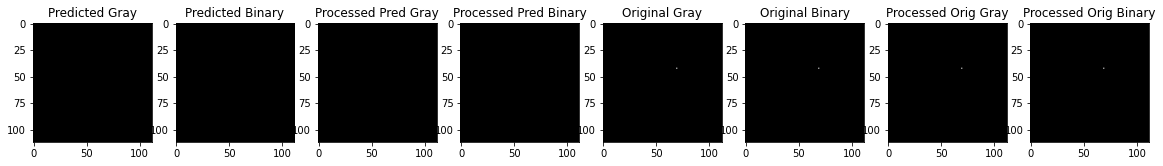

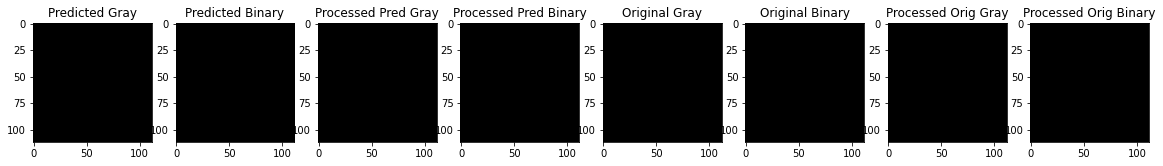

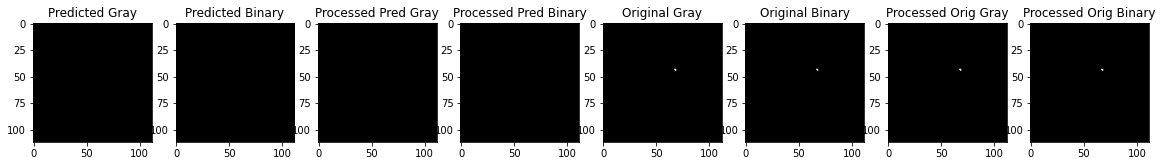

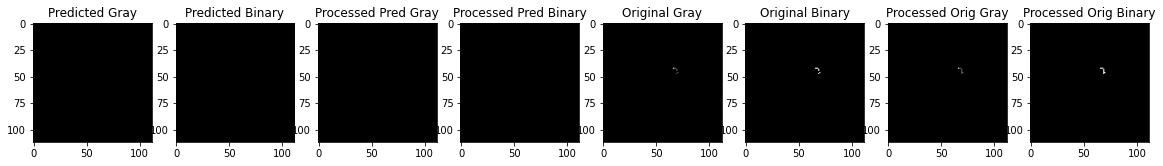

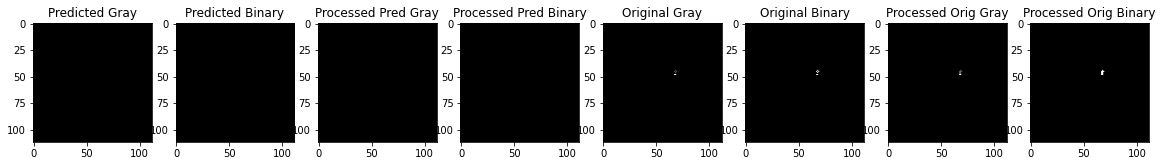

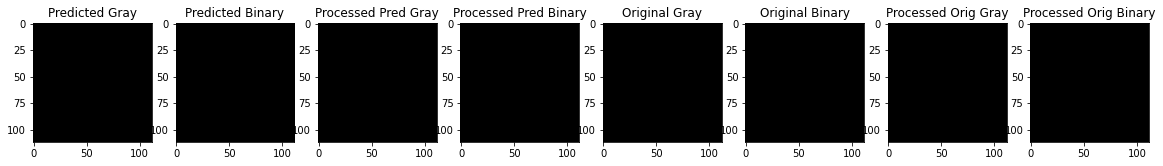

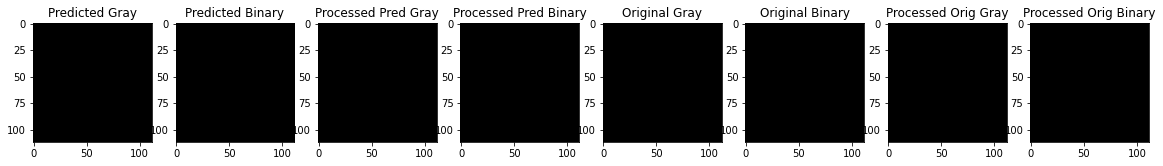

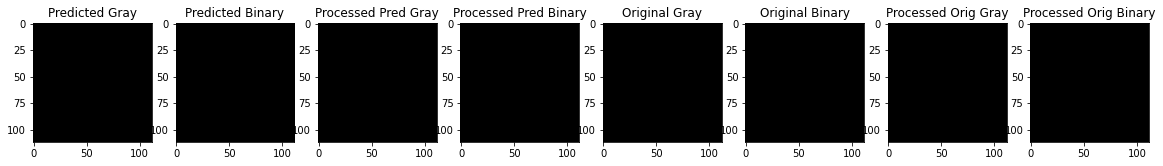

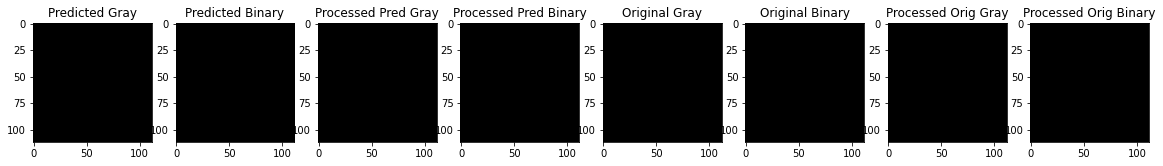

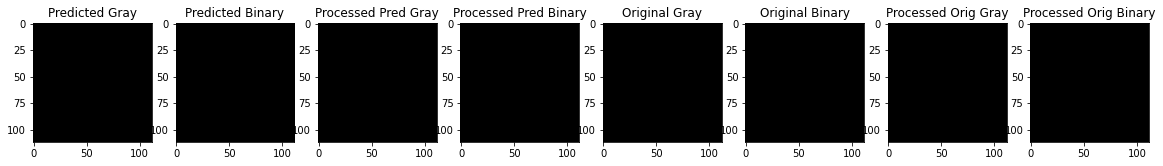

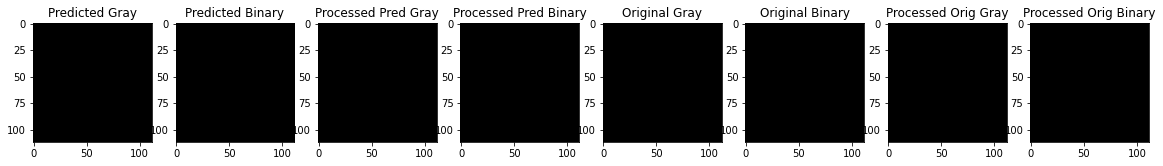

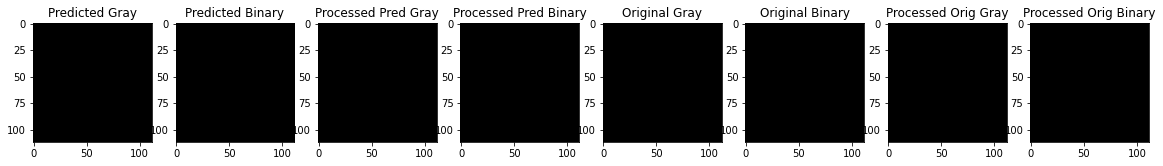

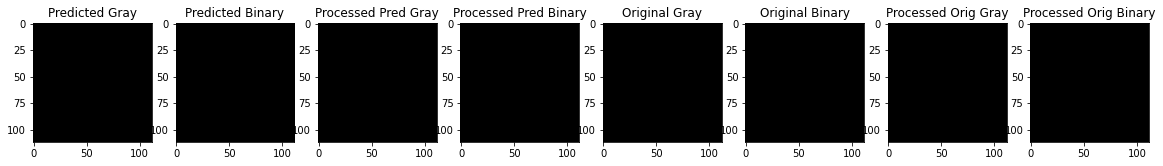

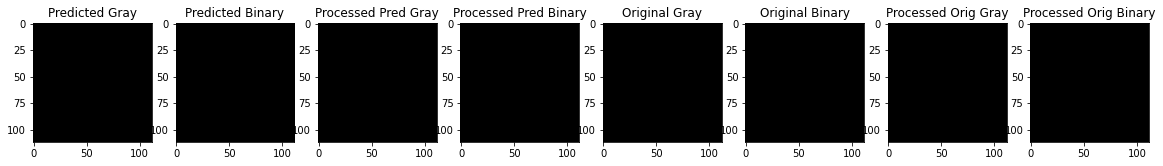

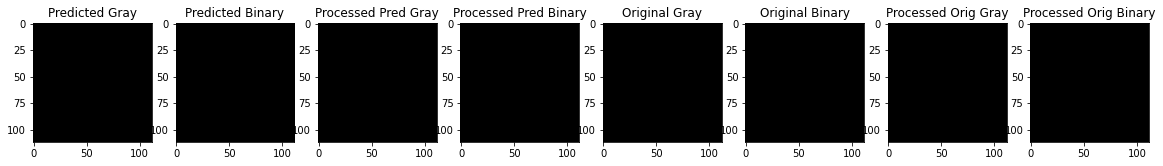

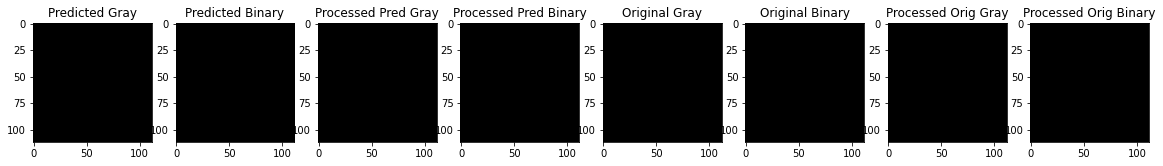

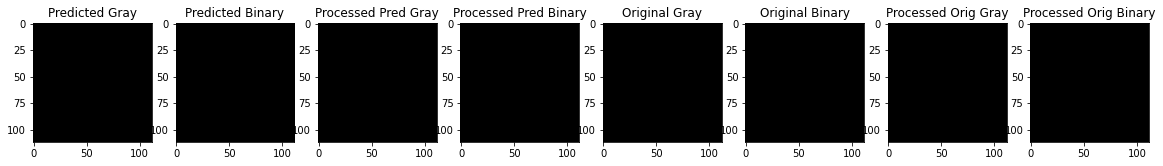

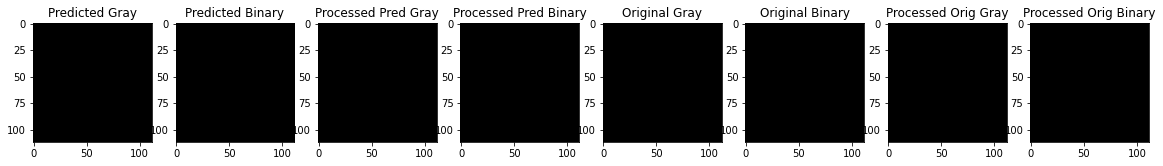

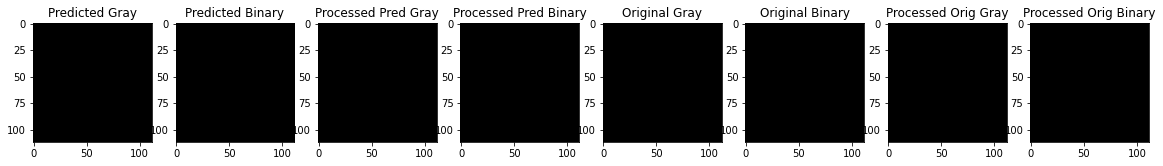

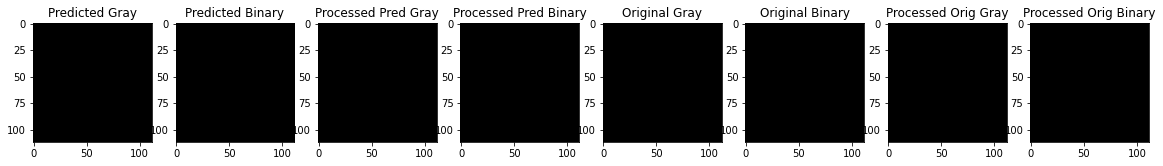

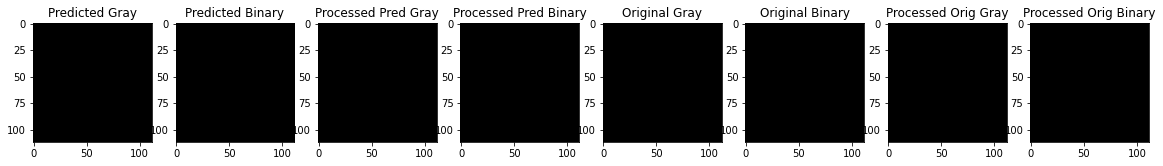

In [10]:
pbinary = [] #predicted binary
pgray = [] #predicted grayscale
label_gray = [] #original gray
label_binary = [] #original binary

binary = [] #processed binary
gray = [] #processed grayscale
original_gray = [] #processed original gray
original_binary = [] #processed original binary
kernel = np.ones((3, 3))
for i in range(96):
    pred = preds[:, i,:,:]
    pred = np.transpose(pred, (1, 2, 0))
    pred = np.rint(pred)
    pred = pred*255
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    pred_gray = pred_gray.astype(np.uint8)
    pgray.append(pred_gray)
    pbinary.append(np.array(pred_gray>0).astype(int))
    pred_gray_closed = cv2.morphologyEx(pred_gray, cv2.MORPH_CLOSE, kernel, iterations=3)
    gray.append(pred_gray_closed)
    pred_binary = np.array(pred_gray_closed>0).astype(int)
    binary.append(pred_binary)
    orig = labels[0][:, i,:,:]
    orig = np.transpose(orig, (1, 2, 0))
    orig = orig*255
    orig_gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    orig_gray = orig_gray.astype(np.uint8)
    label_gray.append(orig_gray)
    label_binary.append(np.array(orig_gray>0).astype(int))
    orig_gray_closed = cv2.morphologyEx(orig_gray, cv2.MORPH_CLOSE, kernel, iterations=3)
    original_gray.append(orig_gray_closed)
    orig_binary = np.array(orig_gray_closed>0).astype(int)
    original_binary.append(orig_binary)
    f, ax_arr = plt.subplots(1, 8, figsize=(20,20))
    ax_arr[0].imshow(pred_gray, cmap='gray')
    ax_arr[0].set_title("Predicted Gray")
    
    ax_arr[1].imshow(pbinary[-1], cmap='gray')
    ax_arr[1].set_title("Predicted Binary")
    
    ax_arr[2].imshow(pred_gray_closed, cmap='gray')
    ax_arr[2].set_title("Processed Pred Gray")
    
    ax_arr[3].imshow(pred_binary, cmap='gray')
    ax_arr[3].set_title("Processed Pred Binary")
    
    ax_arr[4].imshow(orig_gray, cmap='gray')
    ax_arr[4].set_title("Original Gray")
    
    
    ax_arr[5].imshow(label_binary[-1], cmap='gray')
    ax_arr[5].set_title("Original Binary")
    
    ax_arr[6].imshow(orig_gray_closed, cmap='gray')
    ax_arr[6].set_title("Processed Orig Gray")
    
    
    ax_arr[7].imshow(orig_binary, cmap='gray')
    ax_arr[7].set_title("Processed Orig Binary")
    plt.show() 

In [11]:
print("Dice score without processing for binary: %s"%K.get_value(dice_coefficient(K.constant(np.array(label_binary)), K.constant(np.array(pbinary)))))

Dice score without processing for binary: 0.5421262


In [12]:
print("Dice score without processing for gray: %s"%K.get_value(dice_coefficient(K.constant(np.array(label_gray)), K.constant(np.array(pgray)))))

Dice score without processing for gray: 0.44205412


In [13]:
print("Dice score without processing for processed binary: %s"%K.get_value(dice_coefficient(K.constant(np.array(original_binary)), K.constant(np.array(binary)))))

Dice score without processing for processed binary: 0.88134915


In [14]:
print("Dice score without processing for processed gray: %s"%K.get_value(dice_coefficient(K.constant(np.array(original_gray)), K.constant(np.array(gray)))))

Dice score without processing for processed gray: 0.67373645
